# Frozen Lake Environment and Q-Learning


Author: Andrea Pierré <br>
License: MIT License <br>
Taken from OpenAI gym tutorials: https://gymnasium.farama.org/tutorials/training_agents/FrozenLake_tuto/

In [ ]:
#pip install gym==0.26.0

In [30]:
import time

from pathlib import Path
from typing import NamedTuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

import gym as gym
from gym.envs.toy_text.frozen_lake import generate_random_map


sns.set_theme()

# %load_ext lab_black

In [31]:
#We set is_slippery to False. If we set it to True, the transitions are not deterministic and hence the problem is 
#more difficult to solve and we need to explore the environment more to converge to the optimal policy
#We leave it to you to experiment more on this setting and play around with the other hyperparameters


params = {
    'total_episodes':2000,
    'learning_rate':0.8,    # Learning rate
    'gamma':0.95,           # Discount factor
    'epsilon':0.1,          # Exploration probability
    'map_size':5,           # Number of tiles of one side of the squared environment
    'seed':123,             # Define a seed so that we get reproducible results
    'is_slippery':False,    # If true the player will move in intended direction with probability of 1/3 else will move in either perpendicular direction with equal probability of 1/3 in both directions
    'n_runs':20,            # Number of runs
    'action_size':None,     # Number of possible actions
    'state_size':None,      # Number of possible states
    'proba_frozen':0.9,     # Probability that a tile is frozen
    #'savefig_folder':Path(r"C:\Users\faran\OneDrive\Documenti\Federico\ETH\Corso_RL_AIM/_static/img/tutorials/")}
    'savefig_folder':Path('.')/"_static/img/tutorials/"}

params

# Set the seed
rng = np.random.default_rng(params['seed'])

# Create the figure folder if it doesn't exists
params['savefig_folder'].mkdir(parents=True, exist_ok=True)

# The Frozen Lake Environment

In [32]:
env = gym.make(
    "FrozenLake-v1",
    is_slippery=params['is_slippery'],
    render_mode="rgb_array",
    desc=generate_random_map(size=params['map_size'], p=params['proba_frozen']))

# Q-Learning

In [33]:
params['action_size']=env.action_space.n     #we have 4 actions: Up, Down, Left, Right
params['state_size']=env.observation_space.n #we have 25 states since map_size=5 -> n_states=5x5
print(f"Action size: {params['action_size']}")
print(f"State size: {params['state_size']}")


class Qlearning:
    def __init__(self, learning_rate, gamma, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.reset_qtable()

    def update(self, state, action, reward, new_state):
        """Update Q(s,a):= Q(s,a) + lr [R(s,a) + gamma * max Q(s',a') - Q(s,a)]"""
        delta = (
            reward
            + self.gamma * np.max(self.qtable[new_state, :])
            - self.qtable[state, action]
        )
        q_update = self.qtable[state, action] + self.learning_rate * delta
        return q_update

    def reset_qtable(self):
        """Reset the Q-table."""
        #Q-table is a matrix of size n_states x n_actions
        #Alternatively, for memory efficiency, we could have used a dictionary since
        #in the beginning the matrix will be sparse and hence it could be more convenient
        #to instead insert new Q-values in the dictionary as we explore the environment

        self.qtable = np.zeros((self.state_size, self.action_size)) 

class EpsilonGreedy:
    def __init__(self, epsilon):
        
        #In this example, we keep epsilon fixed during training for simplicity. However, we could have also chosen
        #epsilon to be decreasing as time goes on to have faster convergence of the Q-values
        
        self.epsilon = epsilon

    def choose_action(self, action_space, state, qtable):
        """Choose an action `a` in the current world state (s)."""
        # First we randomize a number
        explor_exploit_tradeoff = rng.uniform(0, 1)

        # Exploration
        if explor_exploit_tradeoff < self.epsilon:
            action = action_space.sample()

        # Exploitation (taking the biggest Q-value for this state)
        else:
            # Break ties randomly
            # If all actions are the same for this state we choose a random one
            # (otherwise `np.argmax()` would always take the first one)
            
            if np.all(qtable[state, :]) == qtable[state, 0]:
                action = action_space.sample()
            else:
                action = np.argmax(qtable[state, :])
        return action

Action size: 4
State size: 25


# Running the environment

In [35]:
learner = Qlearning(
    learning_rate=params['learning_rate'],
    gamma=params['gamma'],
    state_size=params['state_size'],
    action_size=params['action_size'])

explorer = EpsilonGreedy(
    epsilon=params['epsilon'])

# Training the Agent

In [36]:
#We are in an infinite horizon setting. When we fall into the lake, we threat this as an absorbing state
#and the episode ends and we restart

def run_env():
    rewards = np.zeros((params['total_episodes'], params['n_runs']))
    steps = np.zeros((params['total_episodes'], params['n_runs']))
    episodes = np.arange(params['total_episodes'])
    qtables = np.zeros((params['n_runs'], params['state_size'], params['action_size']))
    all_states = []
    all_actions = []
    
    #If n_runs=1, we perform only one "experiment", i.e. we run Q-learning on one "realization" of the environment
    #and the transitions. Since the process is stochastic, we may want to run the experiment multiple times
    #to see what is the average behaviour of the algorithm

    for run in range(params['n_runs']):  # Run several times to account for stochasticity
        learner.reset_qtable()  # Reset the Q-table between runs

        for episode in tqdm(
            episodes, desc=f"Run {run}/{params['n_runs']} - Episodes", leave=False
        ):
            state = env.reset(seed=params['seed'])[0]  # Reset the environment
            step = 0
            done = False
            total_rewards = 0

            while not done:
                
                #Perform an action
                action = explorer.choose_action(
                    action_space=env.action_space, state=state, qtable=learner.qtable
                )

                # Log all states and actions
                all_states.append(state)
                all_actions.append(action)

                # Take the action (a) and observe the outcome state(s') and reward (r)
                
                #terminated: boolean that indicates if the agent has reached an absorbing state (either the goal state or if the agent has fallen in the water)
                #truncated: if time limit has been reached (set by default)
                
                new_state, reward, terminated, truncated, info = env.step(action)

                done = terminated or truncated #indicates if the episode is finished (if True) or not
                
                #performing update step based on the observed transition
                learner.qtable[state, action] = learner.update(
                    state, action, reward, new_state
                )

                total_rewards += reward
                step += 1

                #Update the current state with new_state
                state = new_state

            # Log all rewards and steps
            rewards[episode, run] = total_rewards
            steps[episode, run] = step
        qtables[run, :, :] = learner.qtable

    return rewards, steps, episodes, qtables, all_states, all_actions

# Visualization

We convert everything to a Data Frame

In [37]:
def postprocess(episodes, params, rewards, steps, map_size):
    """Convert the results of the simulation in dataframes."""
    res = pd.DataFrame(
        data={
            "Episodes": np.tile(episodes, reps=params['n_runs']),
            "Rewards": rewards.flatten(),
            "Steps": steps.flatten(),
        }
    )
    res["cum_rewards"] = rewards.cumsum(axis=0).flatten(order="F")
    res["map_size"] = np.repeat(f"{map_size}x{map_size}", res.shape[0])

    st = pd.DataFrame(data={"Episodes": episodes, "Steps": steps.mean(axis=1)})
    st["map_size"] = np.repeat(f"{map_size}x{map_size}", st.shape[0])
    return res, st

We want to plot the policy the agent has learned in the end. To do that we will: 
1. extract the best Q-values from the Q-table for each state, 
2. get the corresponding best action for those Q-values, 
3. map each action to an arrow so we can visualize it

In [38]:
def qtable_directions_map(qtable, map_size):
    """Get the best learned action & map it to arrows."""
    qtable_val_max = qtable.max(axis=1).reshape(map_size, map_size)
    qtable_best_action = np.argmax(qtable, axis=1).reshape(map_size, map_size)
    directions = {0: "←", 1: "↓", 2: "→", 3: "↑"}
    qtable_directions = np.empty(qtable_best_action.flatten().shape, dtype=str)
    eps = np.finfo(float).eps  # Minimum float number on the machine
    for idx, val in enumerate(qtable_best_action.flatten()):
        if qtable_val_max.flatten()[idx] > eps:
            # Assign an arrow only if a minimal Q-value has been learned as best action
            # otherwise since 0 is a direction, it also gets mapped on the tiles where
            # it didn't actually learn anything
            qtable_directions[idx] = directions[val]
    qtable_directions = qtable_directions.reshape(map_size, map_size)
    return qtable_val_max, qtable_directions

With the following function, we’ll plot on the left the last frame of the simulation. 
If the agent learned a good policy to solve the task, we expect to see it on the tile of the treasure 
in the last frame of the video. On the right we’ll plot the policy the agent has learned. 
Each arrow will represent the best action to choose for each tile/state.

In [39]:
def plot_q_values_map(qtable, env, map_size):
    """Plot the last frame of the simulation and the policy learned."""
    qtable_val_max, qtable_directions = qtable_directions_map(qtable, map_size)

    # Plot the last frame
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    ax[0].imshow(env.render())
    ax[0].axis("off")
    ax[0].set_title("Last frame")

    # Plot the policy
    sns.heatmap(
        qtable_val_max,
        annot=qtable_directions,
        fmt="",
        ax=ax[1],
        cmap=sns.color_palette("Blues", as_cmap=True),
        linewidths=0.7,
        linecolor="black",
        xticklabels=[],
        yticklabels=[],
        annot_kws={"fontsize": "xx-large"},
    ).set(title="Learned Q-values\nArrows represent best action")
    for _, spine in ax[1].spines.items():
        spine.set_visible(True)
        spine.set_linewidth(0.7)
        spine.set_color("black")
    img_title = f"frozenlake_q_values_{map_size}x{map_size}.png"
    fig.savefig(params['savefig_folder'] / img_title, bbox_inches="tight")
    plt.show()

As a sanity check, we will plot the distributions of states and actions with the following function:

In [40]:
def plot_states_actions_distribution(states, actions, map_size):
    """Plot the distributions of states and actions."""
    labels = {"LEFT": 0, "DOWN": 1, "RIGHT": 2, "UP": 3}

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    sns.histplot(data=states, ax=ax[0], kde=True)
    ax[0].set_title("States")
    sns.histplot(data=actions, ax=ax[1])
    ax[1].set_xticks(list(labels.values()), labels=labels.keys())
    ax[1].set_title("Actions")
    fig.tight_layout()
    img_title = f"frozenlake_states_actions_distrib_{map_size}x{map_size}.png"
    fig.savefig(params['savefig_folder'] / img_title, bbox_inches="tight")
    plt.show()

Now we’ll be running our agent on a few increasing maps sizes: 4x4, 7x7, 9x9, 11x11 <br>
Putting it all together:

Map size: 4x4


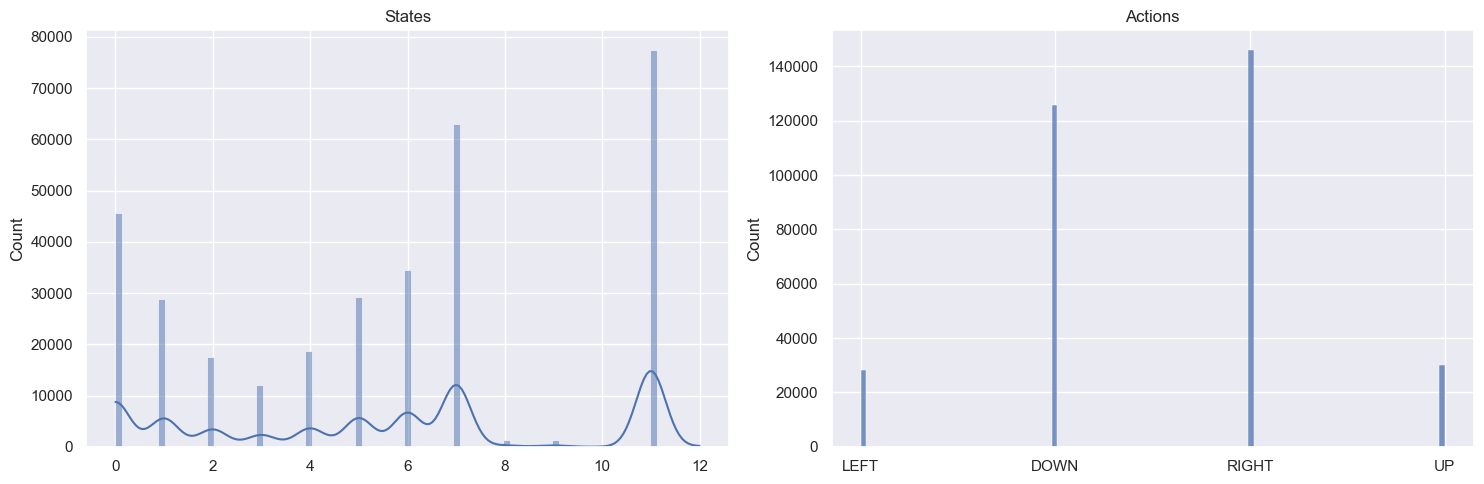

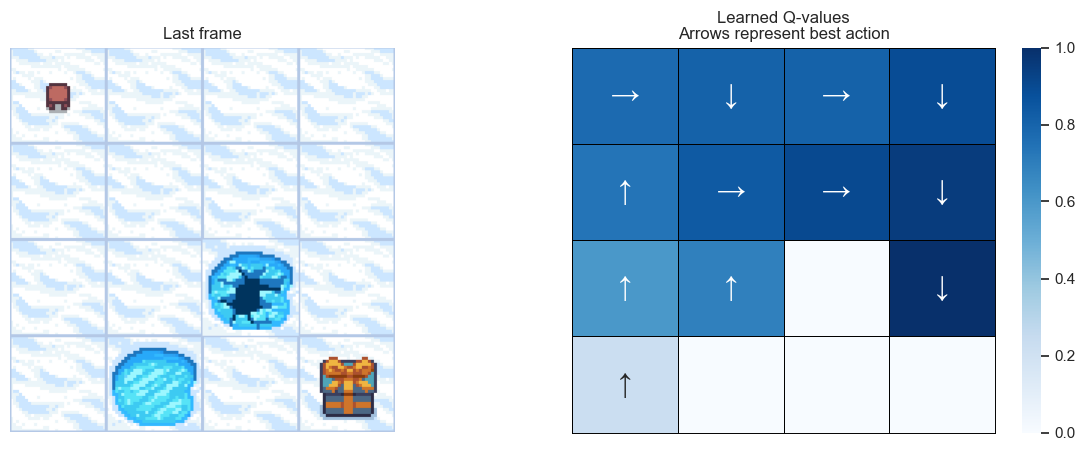

In [ ]:
#map_sizes = [4, 7, 9, 11]
map_sizes=[4]
res_all = pd.DataFrame()
st_all = pd.DataFrame()

for map_size in map_sizes:
    
    env_seed=np.random.randint(1, 10000)
    np.random.seed(env_seed)
    
    env = gym.make(
        "FrozenLake-v1",
        is_slippery=params['is_slippery'],
        render_mode="rgb_array",
        desc=generate_random_map(
            size=map_size, p=params['proba_frozen']))

    params['action_size']=env.action_space.n
    params['state_size']=env.observation_space.n
    env.action_space.seed(
        params['seed']
    )  # Set the seed to get reproducible results when sampling the action space
    learner = Qlearning(
        learning_rate=params['learning_rate'],
        gamma=params['gamma'],
        state_size=params['state_size'],
        action_size=params['action_size'],
    )
    explorer = EpsilonGreedy(
        epsilon=params['epsilon'],
    )

    print(f"Map size: {map_size}x{map_size}")
    rewards, steps, episodes, qtables, all_states, all_actions = run_env()

    # Save the results in dataframes
    res, st = postprocess(episodes, params, rewards, steps, map_size)
    res_all = pd.concat([res_all, res])
    st_all = pd.concat([st_all, st])
    qtable = qtables.mean(axis=0)  # Average the Q-table between runs

    plot_states_actions_distribution(
        states=all_states, actions=all_actions, map_size=map_size
    )  # Sanity check
    plot_q_values_map(qtable, env, map_size)
    
    np.random.seed(env_seed)
    
    env = gym.make(
        "FrozenLake-v1",
        is_slippery=params['is_slippery'],
        render_mode="human",
        desc=generate_random_map(
            size=map_size, p=params['proba_frozen']))
    
    
    #env.render(render_mode='human')
    
    for _ in range(5):
        
        state=env.reset()[0]

        #possible_starting_states=np.array(env.desc==b'F').astype("float64").ravel() + np.array(env.desc==b'S').astype("float64").ravel()
        #state = np.random.choice(np.where(possible_starting_states==1)[0])
        done = False
        total_rewards = 0

        while not done:

            #Take the greedy action
            action = np.argmax(learner.qtable[state, :])

            # Take the action (a) and observe the outcome state(s') and reward (r)

            #terminated: boolean that indicates if the agent has reached an absorbing state (either the goal state or if the agent has fallen in the water)
            #truncated: if time limit has been reached (set by default)

            new_state, reward, terminated, truncated, info = env.step(action)

            done = terminated or truncated #indicates if the episode is finished (if True) or not

            #Update the current state with new_state
            state = new_state


    env.close()